In [2]:
import os
import pandas as pd
import json

df = pd.read_csv('/home/grenders95/710/710_project/data/eval/gpt/gpt_syft_eval.csv')

In [3]:
print(df.dtypes)

repo_name               object
syft_sbom               object
org_repo_name           object
requirements            object
sbom                    object
mod_manifest_newreqs    object
num_dependencies         int64
sbom_data_cleared       object
__index_level_0__        int64
repo_name_from_org      object
dtype: object


In [4]:
import os
import pandas as pd

# Define the root directory containing the subdirectories
root_dir = '/home/grenders95/710/710_project/data/gpt/25_repos_gpt_syft'

# Initialize an empty list to store the data
data = []

# Iterate over each subdirectory in the root directory
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # Initialize a dictionary to store the repo_name and the contents of the JSON files
        record = {'repo_name': subdir}
        
        # Loop through each JSON file name
        for json_file in ['gpt_sbom1.json', 'gpt_sbom2.json', 'gpt_sbom3.json']:
            json_file_path = os.path.join(subdir_path, json_file)
            try:
                # Open the JSON file and read its contents
                with open(json_file_path, 'r') as file:
                    json_content = file.read()
                # Store the content in the corresponding column based on the JSON file name
                record[json_file.replace('.json', '')] = json_content
            except FileNotFoundError:
                print(f"{json_file} not found in {subdir_path}")
                # If a file is not found, store a placeholder or null value
                record[json_file.replace('.json', '')] = None
        
        # Append the record dictionary to the data list
        data.append(record)

# Create a DataFrame from the collected data
df_gpt = pd.DataFrame(data)

# Display the DataFrame
print(df_gpt)

                          repo_name  \
0                        pygame_gui   
1                        androguard   
2                       statsmodels   
3                         augmentor   
4                         pyriemann   
5                               zvt   
6                              SoCo   
7                     yukkimusicbot   
8                        pdfium-lib   
9                            jionlp   
10                           vimGPT   
11              scheduler-component   
12                        starlette   
13              python-myfitnesspal   
14                           elodie   
15              arknightsautohelper   
16  nonsteamlaunchers-on-steam-deck   
17                         oauthlib   
18                     Beast_Bomber   
19                  specter-desktop   
20                      bandcamp-dl   
21                  plusjakartasans   
22                          numexpr   
23                            pyro4   
24                       

In [6]:
# Concatenate the DataFrames along columns
combined_df = pd.concat([df, df_gpt[['gpt_sbom1', 'gpt_sbom2', 'gpt_sbom3']]], axis=1)

# Drop specific columns
columns_to_drop = ['mod_manifest_newreqs', '__index_level_0__', 'repo_name_from_org']
combined_df.drop(columns=columns_to_drop, inplace=True)

# Display the dtypes of the updated DataFrame
print(combined_df.dtypes)

repo_name            object
syft_sbom            object
org_repo_name        object
requirements         object
sbom                 object
num_dependencies      int64
sbom_data_cleared    object
gpt_sbom1            object
gpt_sbom2            object
gpt_sbom3            object
dtype: object


In [35]:
print(combined_df)

                          repo_name  \
0                        pygame_gui   
1                        androguard   
2                       statsmodels   
3                         augmentor   
4                         pyriemann   
5                               zvt   
6                              SoCo   
7                     yukkimusicbot   
8                        pdfium-lib   
9                            jionlp   
10                           vimGPT   
11              scheduler-component   
12                        starlette   
13              python-myfitnesspal   
14                           elodie   
15              arknightsautohelper   
16  nonsteamlaunchers-on-steam-deck   
17                         oauthlib   
18                     Beast_Bomber   
19                  specter-desktop   
20                      bandcamp-dl   
21                  plusjakartasans   
22                          numexpr   
23                            pyro4   
24                       

In [7]:
import json

def flatten_sbom_json(row, column_name):
    # Attempt to handle both string and dictionary input for JSON data
    sbom_data = row[column_name]
    if isinstance(sbom_data, str):
        try:
            sbom_data = json.loads(sbom_data)
        except json.JSONDecodeError:
            return 'Invalid JSON'
    elif not isinstance(sbom_data, dict):
        return 'Unsupported data format'
    
    flattened = []

    try:
        for key, value in sbom_data.items():
            if key != 'packages':  
                flattened.append(f'creation/{key}: {value}')
            else:
                for package in value:
                    for p_key, p_value in package.items():
                        flattened.append(f'packages/{p_key}: {p_value}')
    except AttributeError:
        return 'Error processing JSON structure'
    
    return '\n'.join(flattened)

def apply_flatten_sbom(df, source_column, target_column):
    df.loc[:, target_column] = df.apply(lambda row: flatten_sbom_json(row, source_column), axis=1)

apply_flatten_sbom(combined_df, 'syft_sbom', 'flattened_syft_sbom')
apply_flatten_sbom(combined_df, 'sbom', 'flattened_gt_sbom')
apply_flatten_sbom(combined_df, 'gpt_sbom1', 'flattened_gpt1')
apply_flatten_sbom(combined_df, 'gpt_sbom2', 'flattened_gpt2')
apply_flatten_sbom(combined_df, 'gpt_sbom3', 'flattened_gpt3')

In [11]:
fields_of_interest = [
    "creation/name", "creation/dataLicense", 
    "packages/name", "packages/versionInfo", 
    "packages/downloadLocation", "packages/licenseDeclared", 
    "packages/licenseConcluded"
]

def parse_fields_to_dict(sbom_text, specific_fields):
    """Parse specified field keys from the flattened SBOM text and count their occurrences."""
    fields_dict = {field: 0 for field in specific_fields}  
    
    if pd.isna(sbom_text):  
        return fields_dict
    
    for line in sbom_text.split('\n'):
        if line.strip():  
            field_key = line.split(':')[0].strip()  
            if field_key in fields_dict:
                fields_dict[field_key] += 1  
    
    return fields_dict

def calculate_precision_recall_for_sboms(gen_sbom_text, gt_sbom_text, specific_fields):
    gen_fields_dict = parse_fields_to_dict(gen_sbom_text, specific_fields)
    gt_fields_dict = parse_fields_to_dict(gt_sbom_text, specific_fields)
    
    tp, fp, fn = 0, 0, 0
    
    # Iterate over the specific fields to calculate TP, FP, and FN based on occurrences
    for field in specific_fields:
        if gen_fields_dict[field] > 0 and gt_fields_dict[field] > 0:
            tp += min(gen_fields_dict[field], gt_fields_dict[field])
            fp += max(gen_fields_dict[field] - gt_fields_dict[field], 0)
            fn += max(gt_fields_dict[field] - gen_fields_dict[field], 0)
        elif gen_fields_dict[field] > 0:
            fp += gen_fields_dict[field]
        elif gt_fields_dict[field] > 0:
            fn += gt_fields_dict[field]
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

combined_df['precision_syft_presence'], combined_df['recall_syft_presence'] = zip(*combined_df.apply(lambda row: calculate_precision_recall_for_sboms(row['flattened_syft_sbom'], row['flattened_gt_sbom'], fields_of_interest), axis=1))
combined_df['precision_gpt_presence1'], combined_df['recall_gpt_presence1'] = zip(*combined_df.apply(lambda row: calculate_precision_recall_for_sboms(row['flattened_gpt1'], row['flattened_gt_sbom'], fields_of_interest), axis=1))
combined_df['precision_gpt_presence2'], combined_df['recall_gpt_presence2'] = zip(*combined_df.apply(lambda row: calculate_precision_recall_for_sboms(row['flattened_gpt2'], row['flattened_gt_sbom'], fields_of_interest), axis=1))
combined_df['precision_gpt_presence3'], combined_df['recall_gpt_presence3'] = zip(*combined_df.apply(lambda row: calculate_precision_recall_for_sboms(row['flattened_gpt3'], row['flattened_gt_sbom'], fields_of_interest), axis=1))

In [12]:
combined_df['avg_precision_gpt_presence'] = combined_df[['precision_gpt_presence1', 'precision_gpt_presence2', 'precision_gpt_presence3']].mean(axis=1)

combined_df['avg_recall_gpt_presence'] = combined_df[['recall_gpt_presence1', 'recall_gpt_presence2', 'recall_gpt_presence3']].mean(axis=1)


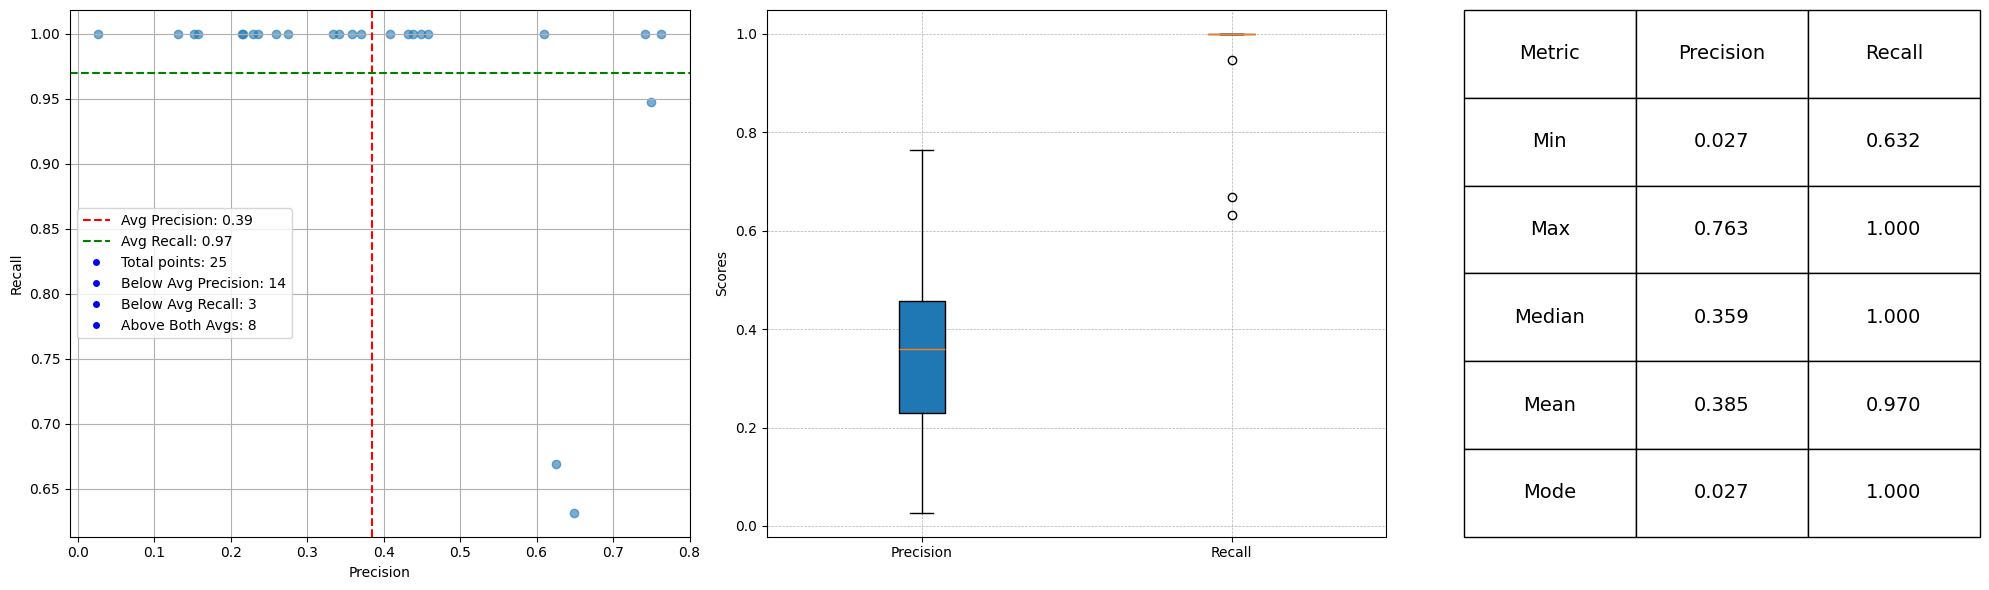

In [22]:
syft_average_precision_fields = combined_df['precision_syft_presence'].mean()
syft_average_recall_fields = combined_df['recall_syft_presence'].mean()
data_points = len(combined_df)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_syft_field(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['precision_syft_presence'], dataframe['recall_syft_presence'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['precision_syft_presence'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['recall_syft_presence'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['precision_syft_presence'] > avg_precision) & (dataframe['recall_syft_presence'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='center left')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['precision_syft_presence'], dataframe['recall_syft_presence']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['precision_syft_presence'].dropna())
    stats_recall = get_statistics(dataframe['recall_syft_presence'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_syft_field(combined_df, syft_average_precision_fields, syft_average_recall_fields, data_points, '/home/grenders95/710/710_project/data/figures/eval/gpt/2syft_scatter_box_field.png')

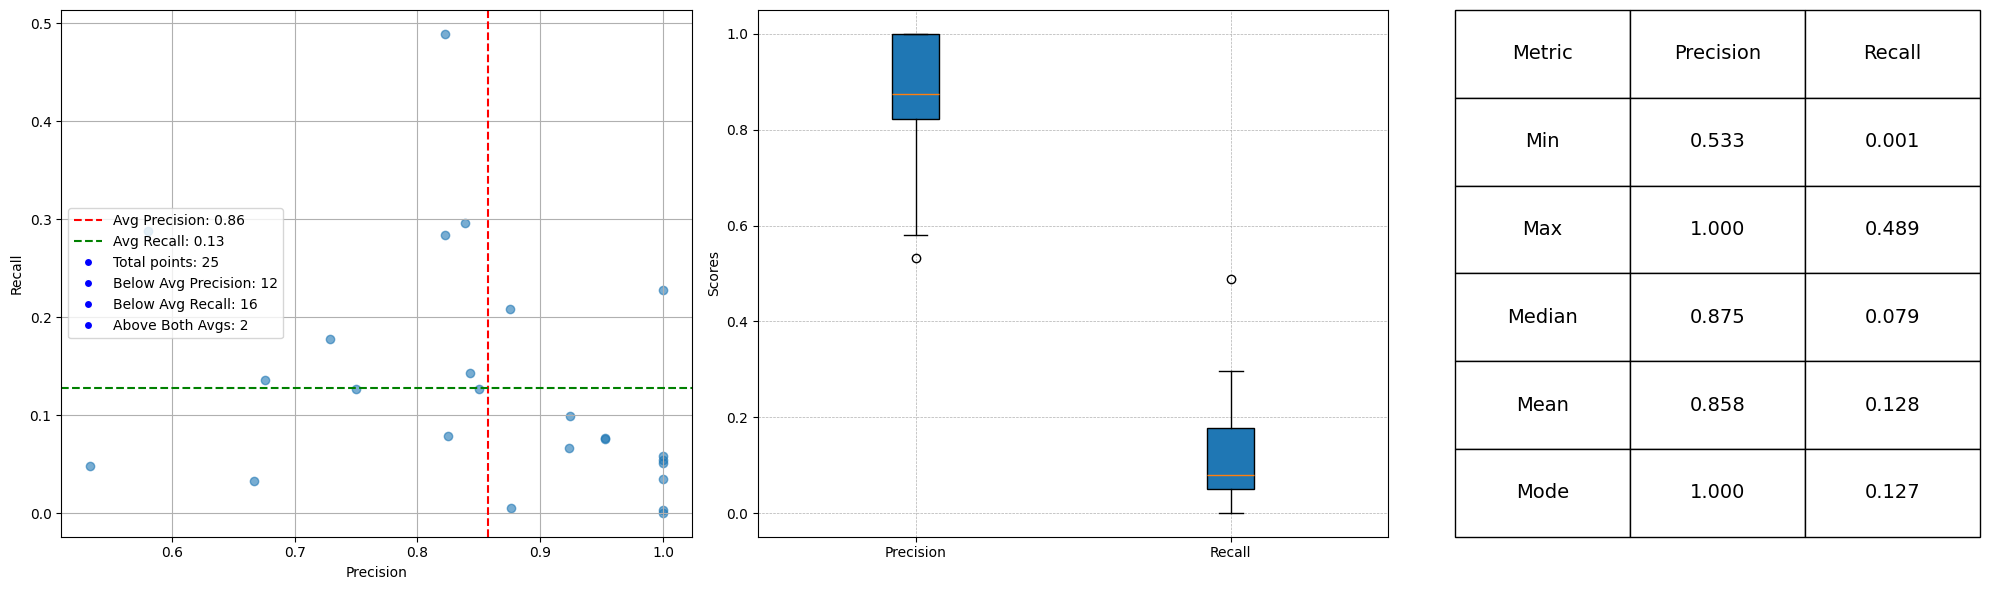

In [13]:
gpt_average_precision_fields = combined_df['avg_precision_gpt_presence'].mean()
gpt_average_recall_fields = combined_df['avg_recall_gpt_presence'].mean()
data_points = len(combined_df)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_gpt_field(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['avg_precision_gpt_presence'], dataframe['avg_recall_gpt_presence'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['avg_precision_gpt_presence'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['avg_recall_gpt_presence'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['avg_precision_gpt_presence'] > avg_precision) & (dataframe['avg_recall_gpt_presence'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='center left')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['avg_precision_gpt_presence'], dataframe['avg_recall_gpt_presence']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['avg_precision_gpt_presence'].dropna())
    stats_recall = get_statistics(dataframe['avg_recall_gpt_presence'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_gpt_field(combined_df, gpt_average_precision_fields, gpt_average_recall_fields, data_points, '/home/grenders95/710/710_project/data/figures/eval/gpt/2gpt_scatter_box_field.png')

In [24]:
def parse_fields_to_dict(sbom_text, fields_of_interest, adjust=False):
    """Parse specific field keys from the flattened SBOM text into a dictionary, optionally adjusting field values."""
    fields_dict = {}
    for line in sbom_text.split('\n'):
        if line.strip():
            field_key, _, value = line.partition(':')
            field_key = field_key.strip()
            value = value.strip()
            if field_key in fields_of_interest:
                if adjust:
                    value = adjust_field_value(field_key, value, is_gt=True)
                if field_key in fields_dict:
                    fields_dict[field_key].append(value)
                else:
                    fields_dict[field_key] = [value]
    return fields_dict

def adjust_field_value(field_key, value, is_gt):
    """Adjust field values based on specified rules, including handling for 'packages/name'."""
    if field_key == "packages/name" and ':' in value:
        return value.split(':', 1)[1].strip()
    return value

def compare_field_values(gen_value, gt_value, field_key):
    """Compare field values, considering special cases for NOASSERTION and empty values."""
    gen_value = adjust_field_value(field_key, gen_value, is_gt=False)
    gt_value = adjust_field_value(field_key, gt_value, is_gt=True)
    
    if field_key in ["packages/downloadLocation", "packages/licenseDeclared", "packages/licenseConcluded"]:
        if (gen_value == "NOASSERTION" and not gt_value) or (gen_value == gt_value):
            return True
    else:
        if gen_value == gt_value:
            return True
    return False

def calculate_precision_recall_value_based(gen_sbom_text, gt_sbom_text, fields_of_interest):
    """Calculate precision and recall focusing on field values for specified fields."""
    gen_fields_dict = parse_fields_to_dict(gen_sbom_text, fields_of_interest, adjust=False)  
    gt_fields_dict = parse_fields_to_dict(gt_sbom_text, fields_of_interest, adjust=True)  

    tp, fp, fn = 0, 0, 0

    for field in gen_fields_dict:
        for gen_value in gen_fields_dict[field]:
            if field in gt_fields_dict:
                matched = False
                for gt_value in gt_fields_dict[field]:
                    if compare_field_values(gen_value, gt_value, field):
                        tp += 1
                        matched = True
                        break  
                if not matched:
                    fp += 1  
            else:
                fp += len(gen_fields_dict[field])  

    for field in gt_fields_dict:
        if field not in gen_fields_dict:
            fn += len(gt_fields_dict[field])  
        else:
            for gt_value in gt_fields_dict[field]:
                if all(not compare_field_values(gen_value, gt_value, field) for gen_value in gen_fields_dict.get(field, [])):
                    fn += 1  

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

In [25]:
fields_of_interest = [
    "creation/dataLicense", "packages/name", "packages/versionInfo",
    "packages/downloadLocation", "packages/licenseDeclared",
    "packages/licenseConcluded"
]

combined_df[['precision_syft_value', 'recall_syft_value']] = combined_df.apply(
    lambda row: calculate_precision_recall_value_based(row['flattened_syft_sbom'], row['flattened_gt_sbom'], fields_of_interest),
    axis=1, result_type='expand'
)

combined_df[['precision_gpt_value1', 'recall_gpt_value1']] = combined_df.apply(
    lambda row: calculate_precision_recall_value_based(row['flattened_gpt1'], row['flattened_gt_sbom'], fields_of_interest),
    axis=1, result_type='expand'
)
combined_df[['precision_gpt_value2', 'recall_gpt_value2']] = combined_df.apply(
    lambda row: calculate_precision_recall_value_based(row['flattened_gpt2'], row['flattened_gt_sbom'], fields_of_interest),
    axis=1, result_type='expand'
)
combined_df[['precision_gpt_value3', 'recall_gpt_value3']] = combined_df.apply(
    lambda row: calculate_precision_recall_value_based(row['flattened_gpt3'], row['flattened_gt_sbom'], fields_of_interest),
    axis=1, result_type='expand'
)

In [26]:
combined_df['avg_precision_gpt_value'] = combined_df[['precision_gpt_value1', 'precision_gpt_value2', 'precision_gpt_value3']].mean(axis=1)

combined_df['avg_recall_gpt_value'] = combined_df[['recall_gpt_value1', 'recall_gpt_value2', 'recall_gpt_value3']].mean(axis=1)

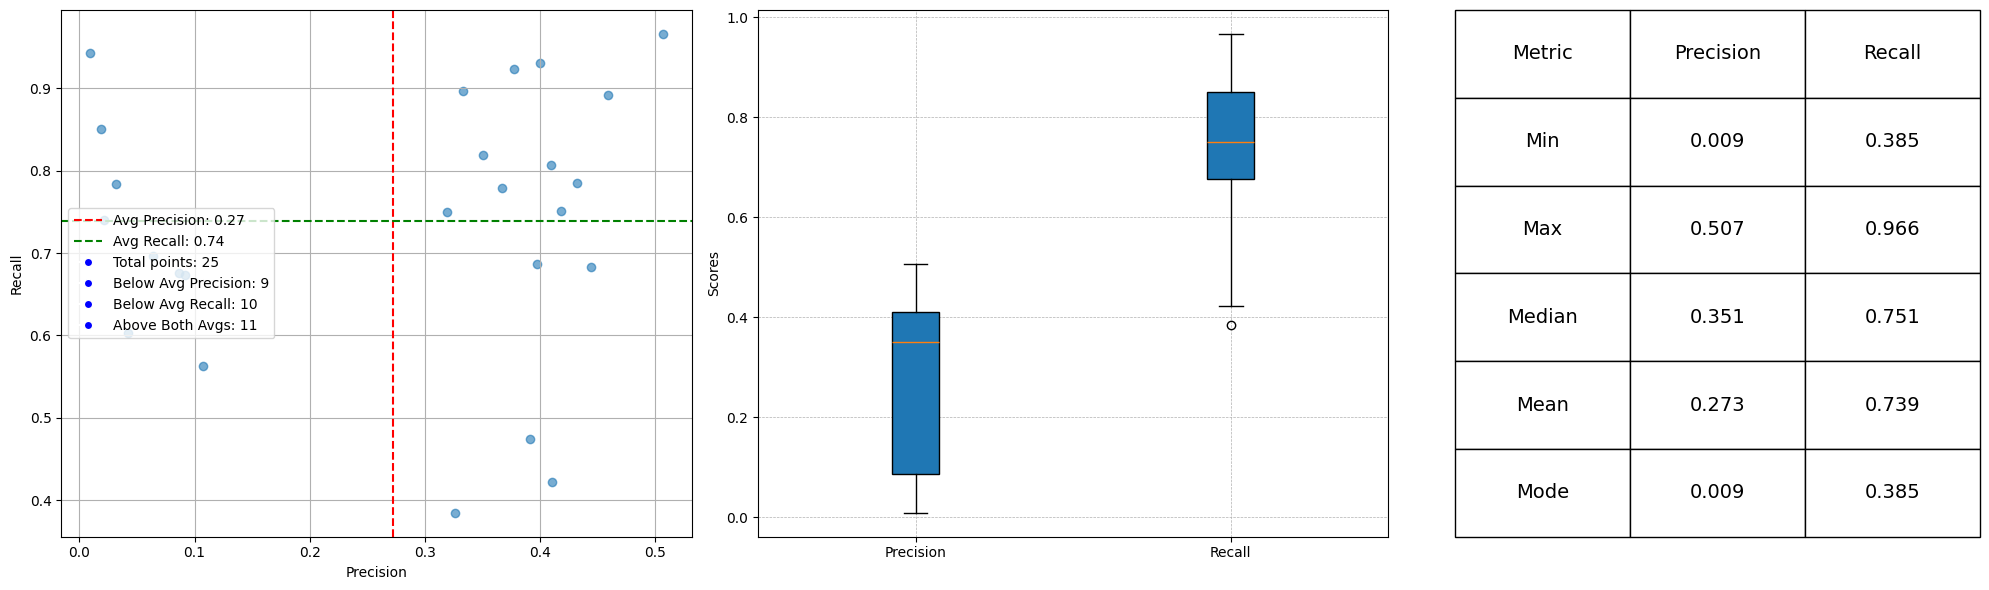

In [27]:
syft_average_precision_value = combined_df['precision_syft_value'].mean()
syft_average_recall_value = combined_df['recall_syft_value'].mean()
data_points = len(combined_df)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_syft_value(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['precision_syft_value'], dataframe['recall_syft_value'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['precision_syft_value'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['recall_syft_value'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['precision_syft_value'] > avg_precision) & (dataframe['recall_syft_value'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='center left')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['precision_syft_value'], dataframe['recall_syft_value']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['precision_syft_value'].dropna())
    stats_recall = get_statistics(dataframe['recall_syft_value'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_syft_value(combined_df, syft_average_precision_value, syft_average_recall_value, data_points, '/home/grenders95/710/710_project/data/figures/eval/gpt/2syft_scatter_box_value.png')

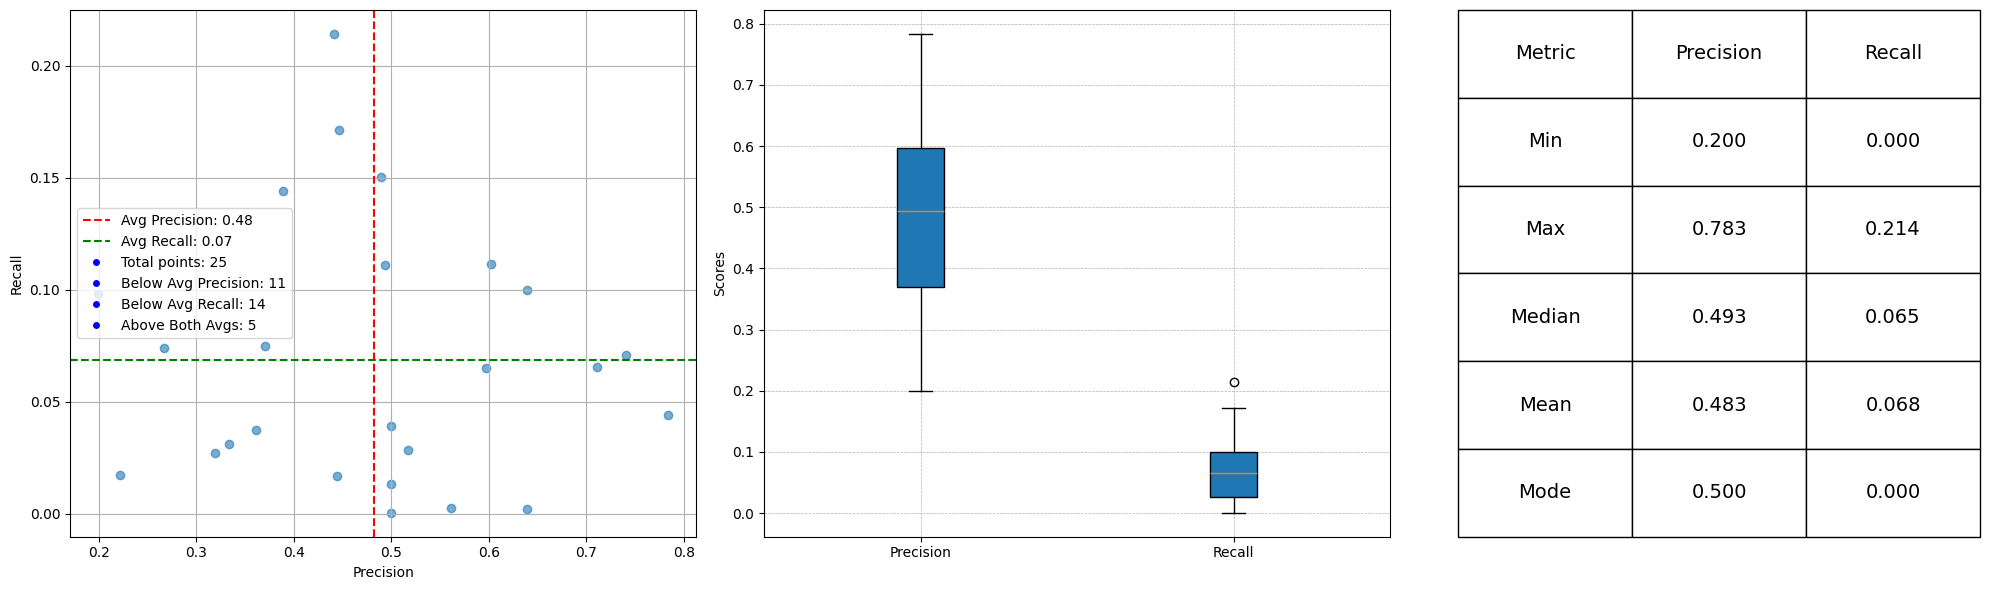

In [28]:
gpt_average_precision_value = combined_df['avg_precision_gpt_value'].mean()
gpt_average_recall_value = combined_df['avg_recall_gpt_value'].mean()
data_points = len(combined_df)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import mode
import numpy as np

def create_plots_with_table_and_boxplot_gpt_value(dataframe, avg_precision, avg_recall, data_points, save_path):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[3, 3, 2.5])

    # Scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(dataframe['avg_precision_gpt_value'], dataframe['avg_recall_gpt_value'], alpha=0.6)
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.axvline(x=avg_precision, color='r', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
    ax1.axhline(y=avg_recall, color='g', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')

    # Calculate additional metrics for the legend
    points_below_avg_precision = dataframe[dataframe['avg_precision_gpt_value'] < avg_precision].shape[0]
    points_below_avg_recall = dataframe[dataframe['avg_recall_gpt_value'] < avg_recall].shape[0]
    points_above_both = dataframe[(dataframe['avg_precision_gpt_value'] > avg_precision) & (dataframe['avg_recall_gpt_value'] > avg_recall)].shape[0]

    # Create custom legend entries
    custom_lines = [mlines.Line2D([], [], color='r', linestyle='--', markersize=15, label=f'Avg Precision: {avg_precision:.2f}'),
                    mlines.Line2D([], [], color='g', linestyle='--', markersize=15, label=f'Avg Recall: {avg_recall:.2f}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Total points: {data_points}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Precision: {points_below_avg_precision}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Below Avg Recall: {points_below_avg_recall}'),
                    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='blue', label=f'Above Both Avgs: {points_above_both}')]

    # Add the custom legend to the plot
    ax1.legend(handles=custom_lines, loc='center left')

    # Box plot
    ax2 = fig.add_subplot(gs[1])
    ax2.boxplot(
        [dataframe['avg_precision_gpt_value'], dataframe['avg_recall_gpt_value']],
        patch_artist=True,
        labels=['Precision', 'Recall']
    )
    ax2.set_ylabel('Scores')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Prepare data for the table
    stats_precision = get_statistics(dataframe['avg_precision_gpt_value'].dropna())
    stats_recall = get_statistics(dataframe['avg_recall_gpt_value'].dropna())

    # Table data
    table_data = [
        ["Min", stats_precision[0], stats_recall[0]],
        ["Max", stats_precision[1], stats_recall[1]],
        ["Median", stats_precision[2], stats_recall[2]],
        ["Mean", stats_precision[3], stats_recall[3]],
        ["Mode", stats_precision[4] or "N/A", stats_recall[4] or "N/A"]
    ]

    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    table = ax3.table(cellText=table_data, colLabels=['Metric', 'Precision', 'Recall'], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def format_statistic(value):
    if value is None or (isinstance(value, np.ndarray) and value.size == 0):
        return "N/A"
    return f"{value:.3f}"

def get_statistics(column):
    mode_result = mode(column, nan_policy='omit')
    mode_val = mode_result.mode if mode_result.mode.size > 0 else None
    return [
        format_statistic(np.min(column)),
        format_statistic(np.max(column)),
        format_statistic(np.median(column)),
        format_statistic(np.mean(column)),
        format_statistic(mode_val)
    ]

create_plots_with_table_and_boxplot_gpt_value(combined_df, gpt_average_precision_value, gpt_average_recall_value, data_points, '/home/grenders95/710/710_project/data/figures/eval/gpt/2gpt_scatter_box_value.png')